# Step -5

### Step - 1 (Recap)
- The model is still large but working.
- We see some over-fitting.
- Accuracy needs improvement.

### Step - 2 (Recap) 
- Parameters reduced to less than 10k (8412) by implementing GAP.
- Overfitting is eliminated. In fact we see some underfitting.
- Accuracy needs improvement. Accuracy has decreased as compared to Part -1.
- From the training loss curve it seems that reducing the learning rate might improve the training accuracy as the curve seems to be divergent after few epochs.

### Step - 3 (Recap)
- Parameters reduced to 7216.
- No significant improvement in accuracy.
- Introduced stepped reduction of learning rate.

### Step - 4 (Recap)
- Introduce regularization methods like dropout and batch normalization.
- Marginal improvement in accuracy.
- Model seems to underfit.

### Step - 5 (Action Items)
- Update the network to add more parameters
- Shift maxpool layer after 3 convolutions
- Try removing Drop out
- Introduce Rotational Transformation

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary

## Data Transformations

We continue with existing transformation from Part -1 

Following transformations have been carried forward

1.   ToTensor conversion
2.   Normalize using mean and std of the entire MNST dataset - ((0.1307,), (0.3081,)) respectively.

# Building transformation rules for our dataset

In [ ]:
# Using the mean and standard deviation values to normalize the dataset.
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std for MNIST dataset
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])


# Dataset and Creating Train/Test Split with transformation rules.

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

Checking some of the statistics around our data.

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Min: tensor(-0.4242)
 - Max: tensor(2.8215)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


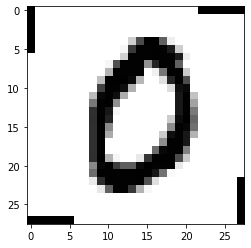

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Min:', torch.min(train_data))
print(' - Max:', torch.max(train_data))
# The data has already been transformed using Mean and Standard deviation. 
# Going for a mean and standard deviation again would give us zeros and ones.
#print(' - Mean:', torch.mean(train_data)) 
#print(' - Std:', torch.std(train_data))
#print(' - Var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

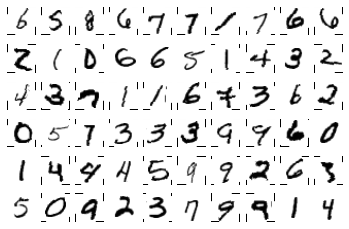

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# Rebuilding the network again with a better readability and with fewer parameters.
# The out channels have been set in accordance with raising to the power 2 for a better GPU utilization.
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            #nn.Dropout(dropout_value)
            ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            #nn.Dropout(dropout_value)
        ) # output_size = 22
        
        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) 
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        
        
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        ) # output_size = 9

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            #nn.Dropout(dropout_value)
        ) # output_size = 7
                

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value)
        ) # output_size = 1
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Parameters of our new model as below

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"This network is being trained on {device}{('.' if use_cuda else ' because cuda is not available.')}")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

This network is being trained on cuda.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 32, 22, 22]           4,608
              ReLU-8           [-1, 32, 22, 22]               0
       BatchNorm2d-9           [-1, 32, 22, 22]              64
           Conv2d-10            [-1, 8, 22, 22]             256
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Conv2d-13             [-1, 16, 9, 9]           1,152


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Observation

We still have less than 10k parameters. We will see how this model performs.

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Hence we are setting the graident to zero at the start of each loop so that the parameters update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1674429029226303 Batch_id=468 Accuracy=90.30: 100%|██████████| 469/469 [00:43<00:00, 10.75it/s]



Test set: Average loss: 0.1675, Accuracy: 9730/10000 (97.30%)

EPOCH: 1


Loss=0.13659818470478058 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:43<00:00, 10.67it/s]



Test set: Average loss: 0.0984, Accuracy: 9808/10000 (98.08%)

EPOCH: 2


Loss=0.08399995416402817 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:44<00:00, 10.59it/s]



Test set: Average loss: 0.0671, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.1781398206949234 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]



Test set: Average loss: 0.0580, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.07323019951581955 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s]



Test set: Average loss: 0.0461, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.048417482525110245 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:43<00:00, 10.69it/s]



Test set: Average loss: 0.0534, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.02868456207215786 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:43<00:00, 10.66it/s]



Test set: Average loss: 0.0420, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.1068548932671547 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0354, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.06306710094213486 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:44<00:00, 10.53it/s]



Test set: Average loss: 0.0386, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.06472034007310867 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:44<00:00, 10.52it/s]



Test set: Average loss: 0.0342, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.014991248957812786 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:44<00:00, 10.56it/s]



Test set: Average loss: 0.0328, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.09922853857278824 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0314, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.012268628925085068 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:44<00:00, 10.50it/s]



Test set: Average loss: 0.0337, Accuracy: 9912/10000 (99.12%)

EPOCH: 13


Loss=0.03028496354818344 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:44<00:00, 10.56it/s]



Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


Loss=0.059591736644506454 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:44<00:00, 10.52it/s]



Test set: Average loss: 0.0295, Accuracy: 9925/10000 (99.25%)



Text(0.5, 1.0, 'Test Accuracy')

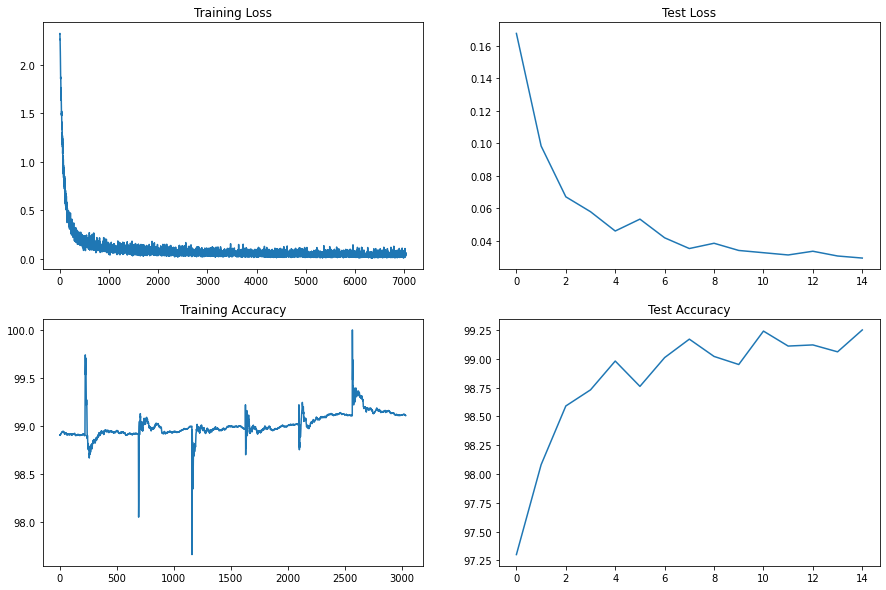

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Retrain with stepped Learning Rate


In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    if (epoch >= 5):
      scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.16060525178909302 Batch_id=468 Accuracy=91.26: 100%|██████████| 469/469 [00:44<00:00, 10.50it/s]



Test set: Average loss: 0.1337, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.09834230691194534 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:44<00:00, 10.59it/s]



Test set: Average loss: 0.0837, Accuracy: 9826/10000 (98.26%)

EPOCH: 2


Loss=0.11314105242490768 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:44<00:00, 10.63it/s]



Test set: Average loss: 0.0607, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.06702690571546555 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:44<00:00, 10.64it/s]



Test set: Average loss: 0.0603, Accuracy: 9863/10000 (98.63%)

EPOCH: 4


Loss=0.07211808115243912 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:44<00:00, 10.64it/s]



Test set: Average loss: 0.0428, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.05122208967804909 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:44<00:00, 10.56it/s]



Test set: Average loss: 0.0431, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.07544820010662079 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0348, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.02292143553495407 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0341, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.0646686851978302 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:44<00:00, 10.64it/s]



Test set: Average loss: 0.0276, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.06813278049230576 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:44<00:00, 10.64it/s]



Test set: Average loss: 0.0272, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.07297471910715103 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s]



Test set: Average loss: 0.0268, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.042073484510183334 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0262, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.03580964729189873 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0260, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.04770702123641968 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0263, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.01927895098924637 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0258, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

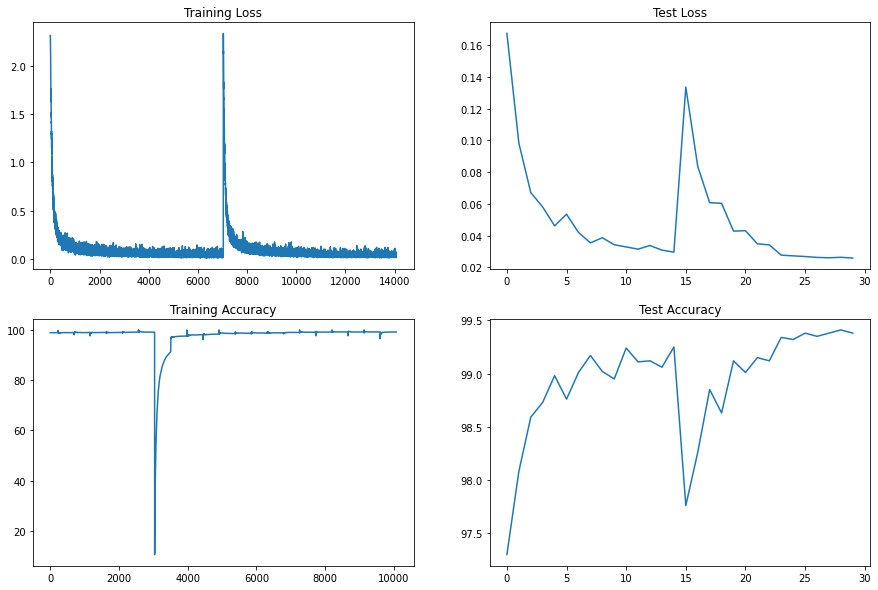

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Inference:
- The model parameters are slightly more than 10k. 
- The model shows consistant 99.4% accuracy for last few epochs.
- The difference between training and test accuracy is also minimal.